In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
cwd = Path.cwd()
price_path = cwd / 'data' / 'Metro_median_sale_price_now_uc_sfrcondo_month.csv'
zhvi_path = cwd / 'data' / 'Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (2).csv'

price_df = pd.read_csv(price_path)
zhvi_df = pd.read_csv(zhvi_path)

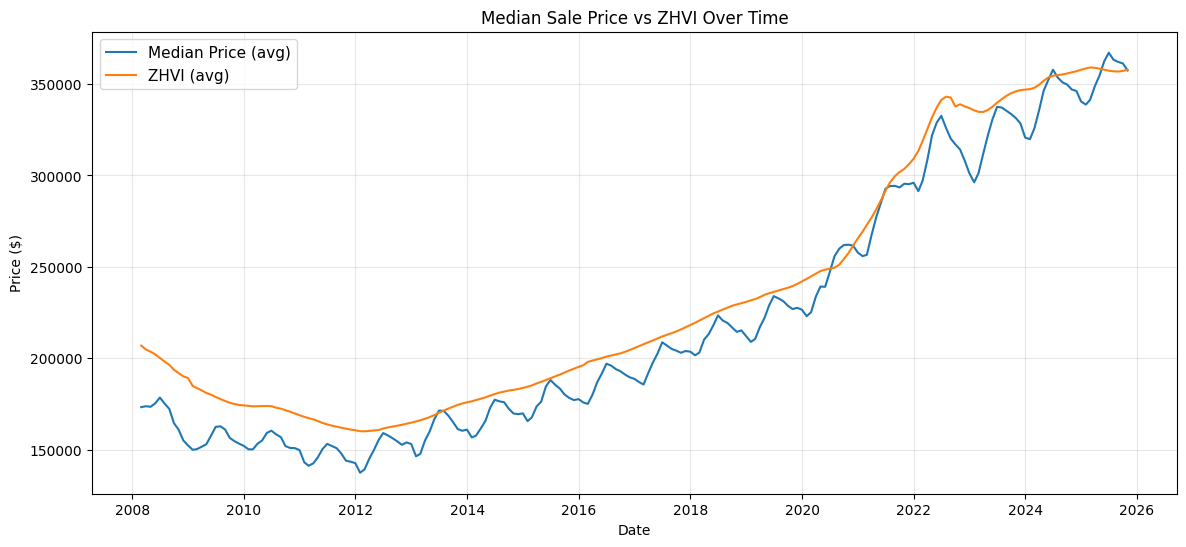

In [10]:
# melt to convert dates to rows
metadata_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
price_long = price_df.melt(id_vars=metadata_cols, var_name='date', value_name='median_price')
zhvi_long = zhvi_df.melt(id_vars=metadata_cols, var_name='date', value_name='zhvi')

price_long['date'] = pd.to_datetime(price_long['date'])
zhvi_long['date'] = pd.to_datetime(zhvi_long['date'])

# merge on date and region
merged = pd.merge(price_long[['RegionName', 'date', 'median_price']], 
                  zhvi_long[['RegionName', 'date', 'zhvi']], 
                  on=['RegionName', 'date'], how='inner')

fig, ax = plt.subplots(figsize=(14, 6))
dates = merged['date'].unique()
dates = sorted(dates)

# plot
daily_avg_price = merged.groupby('date')['median_price'].mean()
daily_avg_zhvi = merged.groupby('date')['zhvi'].mean()

ax.plot(daily_avg_price.index, daily_avg_price.values, label='Median Price (avg)')
ax.plot(daily_avg_zhvi.index, daily_avg_zhvi.values, label='ZHVI (avg)')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('Median Sale Price vs ZHVI Over Time')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()


Looks like the ZHVI overestimates the Median Sale Price

In [19]:
# melt, clean, merge, and compare price vs ZHVI
price_long['date'] = pd.to_datetime(price_long['date'], errors='coerce')
zhvi_long['date'] = pd.to_datetime(zhvi_long['date'], errors='coerce')

# merge on RegionName and date
price_long['RegionName'] = price_long['RegionName'].astype(str)
zhvi_long['RegionName'] = zhvi_long['RegionName'].astype(str)

merged = pd.merge(price_long, zhvi_long, on=['RegionName','date'], how='inner')

# calculate how far off ZHVI is on average
merged['rel_diff'] = (merged['zhvi'] - merged['median_price']) / merged['median_price']
merged['StateName'] = merged['StateName_x']  # Use StateName from price_long
mean_bias = merged['rel_diff'].mean()


print(f'\nOn average, ZHVI is {abs(mean_bias)*100:.2f}% higher than median sale price')
print(f'Mean bias: {mean_bias:.4f} ({mean_bias*100:.2f}%)')
print(f'Median bias: {merged["rel_diff"].median():.4f} ({merged["rel_diff"].median()*100:.2f}%)')
print(f'Std deviation: {merged["rel_diff"].std():.4f}')
print(f'Sample size: {len(merged)} region-date pairs')


On average, ZHVI is 7.76% higher than median sale price
Mean bias: 0.0776 (7.76%)
Median bias: 0.0661 (6.61%)
Std deviation: 0.1335
Sample size: 82431 region-date pairs


ZHVI BIAS BY STATE
State  Mean Bias %  Sample Size
   PA    16.555420         3862
   WI    16.234905         2672
   NJ    15.097502          852
   ND    13.903689          404
   RI    13.436156          213
   DE    13.325729          409
   TN    13.069740         2976
   MD    12.920825          639
   VT    12.585318          293
   MA    11.994573         1065
   MI    11.644558         3606
   AK    11.195684          211
   WY    11.195358          583
   NH    10.618387          639
   FL    10.137754         4800
   MN    10.112779         1275
   HI     9.977978          554
   NE     9.925869          426
   NY     9.872321         2553
   CT     9.845436         1065
   OH     9.651168         2342
   CO     9.396261         2127
   WA     8.874888         2745
   ID     8.603244          852
   AZ     8.342490         1491
   UT     8.109185         1256
   MT     7.874484          601
   NV     7.470536          426
   ME     7.440559          639
   SC     7.168970   

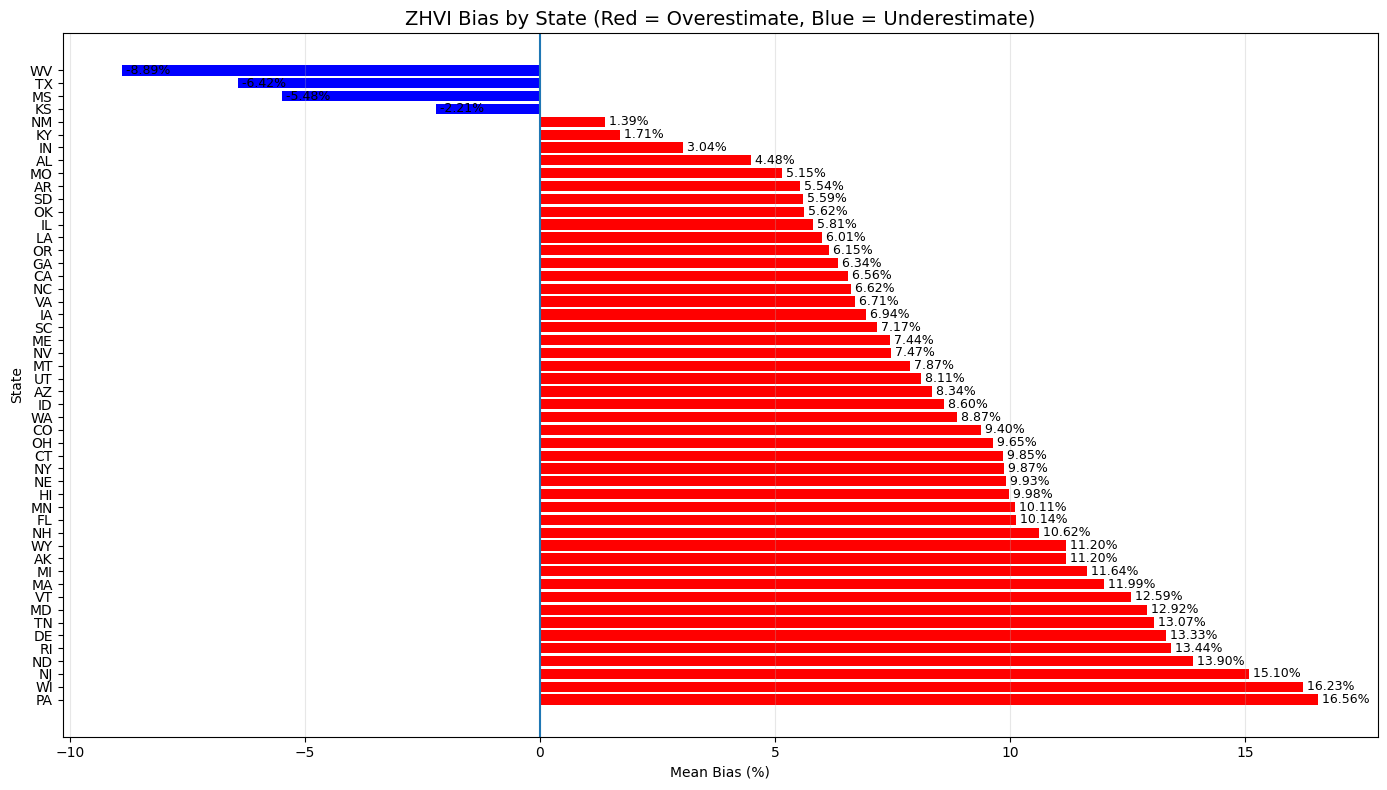

In [ ]:
# calculate bias by state
state_bias = merged.groupby('StateName')['rel_diff'].agg(['mean', 'count']).reset_index()
state_bias.columns = ['State', 'Mean Bias', 'Sample Size']
state_bias['Mean Bias %'] = state_bias['Mean Bias'] * 100

# sort by mean bias descending
state_bias = state_bias.sort_values('Mean Bias %', ascending=False)

print('ZHVI BIAS BY STATE')
print(state_bias[['State', 'Mean Bias %', 'Sample Size']].to_string(index=False))

# create visualization
fig, ax = plt.subplots(figsize=(14, 8))
states = state_bias['State']
mean_biases = state_bias['Mean Bias %']
colors = ['red' if x > 0 else 'blue' for x in mean_biases]

bars = ax.barh(states, mean_biases, color=colors)
ax.axvline(x=0)
ax.set_xlabel('Mean Bias (%)')
ax.set_ylabel('State')
ax.set_title('ZHVI Bias by State (Red = Overestimate, Blue = Underestimate)', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# add value labels on bars
for i, (state, bias) in enumerate(zip(states, mean_biases)):
    ax.text(bias, i, f' {bias:.2f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()